In [1]:
import pandas as pd
import numpy as np
import itertools as itr
import os,re,time
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score,precision_recall_curve, auc,accuracy_score,roc_auc_score, roc_curve, recall_score, classification_report,f1_score
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")



from imblearn.over_sampling import SMOTE,SVMSMOTE
from imblearn.under_sampling import TomekLinks,RandomUnderSampler

from dummyPy import OneHotEncoder

/root/anaconda3/envs/shopin/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/anaconda3/envs/shopin/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/anaconda3/envs/shopin/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/anaconda3/envs/shopin/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/anaconda3/envs/shopin/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Read train csv
train_data = pd.read_csv('data_train.csv')
data = train_data.copy()

In [3]:
def col_null(data):
    '''
    UDF() - Columns with null values
    Args - data- Dataframe
    
    Returns - columns with null values present
    '''
    for col in data.columns:
        if data[col].isnull().sum()>0:
            yield col
null_col = list(col_null(train_data))
print(null_col)

['num18', 'num19', 'num20', 'num22', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8', 'cat10', 'cat12']


In [4]:
# Percentage of data missing wrt whole data

print(train_data[null_col].isnull().sum()/train_data.shape[0] *100)

direct_drop_col = ['cat6','cat8']

# cat6,cat8 - directly dropped from train_data. Mostly imputing the missing data leads to a better model but here we dont know about importance of each varible.
# Theoretically 25-30 % missing data should be handled.
# Here we dont know the significance of the variable i.e, how important it is to the business
# The provided dataset lacks in explaining each column and it significance.

num18    18.105537
num19     0.000839
num20     0.000168
num22     7.158893
cat1      0.036409
cat2      0.013926
cat3      0.975503
cat4      0.017953
cat5      0.000839
cat6     69.092617
cat8     44.786577
cat10     1.930034
cat12     0.095638
dtype: float64


In [5]:
def data_eda_generator(data,data_columns):
    '''
    UDF() - Finds the number of unique values in a column
    Args - data,columns of data
    
    Returns - data_column_name,No. of unique values, data_type of column
    
    '''  
    for index,value in enumerate(data_columns):
        yield value,len(data[value].unique()),type(data[value][0])
        
        
        

list(data_eda_generator(train_data,train_data.columns))
 
    

[('id', 596000, numpy.int64),
 ('num1', 8, numpy.int64),
 ('num2', 12, numpy.int64),
 ('num3', 2, numpy.int64),
 ('num4', 2, numpy.int64),
 ('num5', 2, numpy.int64),
 ('num6', 2, numpy.int64),
 ('num7', 2, numpy.int64),
 ('num8', 2, numpy.int64),
 ('num9', 2, numpy.int64),
 ('num10', 2, numpy.int64),
 ('num11', 5, numpy.int64),
 ('num12', 14, numpy.int64),
 ('num13', 2, numpy.int64),
 ('num14', 2, numpy.int64),
 ('num15', 2, numpy.int64),
 ('num16', 10, numpy.float64),
 ('num17', 19, numpy.float64),
 ('num18', 5013, numpy.float64),
 ('num19', 5, numpy.float64),
 ('num20', 184, numpy.float64),
 ('num21', 70482, numpy.float64),
 ('num22', 850, numpy.float64),
 ('num23', 15, numpy.float64),
 ('der1', 10, numpy.float64),
 ('der2', 10, numpy.float64),
 ('der3', 10, numpy.float64),
 ('der4', 6, numpy.int64),
 ('der5', 7, numpy.int64),
 ('der6', 11, numpy.int64),
 ('der7', 10, numpy.int64),
 ('der8', 11, numpy.int64),
 ('der9', 8, numpy.int64),
 ('der10', 26, numpy.int64),
 ('der11', 20, nump

In [6]:
def change_data_type(data,type_,pattern):
    '''
    UDF() - Converts data type of columns
    Args - data- Dataframe
           data_type - data type in which we want to convert the column
           pattern - for a particular column which starts with a particular pattern
    
    Returns - None
    '''
    for index,value in enumerate(data.columns):
        if re.search(pattern , str(value)):
            data[value] = data[value].astype(type_)
    return data 

# train_data_  = change_data_type(train_data,str,pattern='cat')

In [7]:
# Creating dataframe for imputation
# Selecting columns with null values
# Direct_drop_col = 'cat6','cat8'

drop_col = null_col + ['id'] + ['target']

data_impute = data.drop(columns=drop_col)

data_impute = change_data_type(data_impute,'category','cat')

y_labels_columns = [x for x in null_col if x not in direct_drop_col]

# Missing Values Imputation

In [8]:
data_pr = change_data_type(data,'category','cat')

In [9]:
# rc = RandomForestClassifier(n_estimators = 10, n_jobs=7,warm_start=True)
# rg = RandomForestRegressor(n_estimators=10, n_jobs=7,warm_start=True)

def impute_generator(data,columns):
    '''
    UDF() - Imputation of null values using Random Forest.
    
    Args - data- Dataframe
           columns - Column names with null values
   
    Returns - tuples
              [0]-Colname
              [1]- y_test - Predicted values for nul values
    
    '''

    for col in columns:
                
        rc = RandomForestClassifier(n_estimators = 10, n_jobs=3,warm_start=False)
        rg = RandomForestRegressor(n_estimators=10, n_jobs=3,warm_start=False)
        lableenc = LabelEncoder()

        
        
        drop_list = [x for x in columns if x not in [col]]
        drop_list = drop_list + ['id','cat6','cat8']
        print('drop_list ::','\t',drop_list)
        data_ = data.drop(columns=drop_list)  
        
        
        missing_perc = data[col].isnull().sum()/data.shape[0] 
        sample_from_data = 2*missing_perc
        
        
        train_sample = data_.sample(frac=sample_from_data) # to control class imbalance
        
        
        train_  = train_sample[train_sample[col].isnull()==False]
        train_impute = train_.drop(columns=[col])
        
        
        y_train = list(train_[train_[col].isnull()==False][col])
        
  
        test_  = data_[data_[col].isnull()]
        test_impute = test_.drop(columns=[col])
        
           
        if data[col].dtype=='int64' or data[col].dtype=='float64' or data[col].dtype=='float16':
            classifier = rg
            print('performing regression')
        else:
            classifier = rc
            print('performing classification')

        
        print('%s fitting in model'%col)
        
        y_train_enc = lableenc.fit_transform(y_train)
        
        
        print('Shape of training data for rf :',train_impute.shape)
        
        classifier.fit(train_impute,y_train)
        
        y_test = classifier.predict(test_impute)
        
        print('%s prediction done'%col)
        
        col_name = col
        
        yield col_name,y_test
  

In [10]:
out_imputed = list(impute_generator(data=data_pr,columns=y_labels_columns))

drop_list :: 	 ['num19', 'num20', 'num22', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat10', 'cat12', 'id', 'cat6', 'cat8']
performing regression
num18 fitting in model
Shape of training data for rf : (176843, 44)
num18 prediction done
drop_list :: 	 ['num18', 'num20', 'num22', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat10', 'cat12', 'id', 'cat6', 'cat8']
performing regression
num19 fitting in model
Shape of training data for rf : (10, 44)
num19 prediction done
drop_list :: 	 ['num18', 'num19', 'num22', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat10', 'cat12', 'id', 'cat6', 'cat8']
performing regression
num20 fitting in model
Shape of training data for rf : (2, 44)
num20 prediction done
drop_list :: 	 ['num18', 'num19', 'num20', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat10', 'cat12', 'id', 'cat6', 'cat8']
performing regression
num22 fitting in model
Shape of training data for rf : (79233, 44)
num22 prediction done
drop_list :: 	 ['num18', 'num19', 'num20', 'num22', 'cat2', 'cat3', 'c

In [11]:
def update_data(data,list_):
    '''
    UDF() - Update the null values with predicted values
    
    Args - Data - dataframe
           list_ - output list of impute_generator
           
   Returns - Imputed Dataframe
    
    '''
    
    data_  = data
    
    for element in list_:
        
        col_name = element[0]
        
        print('Processing {}'.format(col_name))
        
        pred_values = element[1]
      
        test_index = data_[data_[col_name].isnull()][col_name].index
        
        # Update values
        
        data_.loc[test_index,col_name] = pred_values
        
        
    return data_
        

In [12]:
imputed_data = update_data(data=data_pr,list_=out_imputed)


Processing num18
Processing num19
Processing num20
Processing num22
Processing cat1
Processing cat2
Processing cat3
Processing cat4
Processing cat5
Processing cat10
Processing cat12


In [13]:
# Dropping 'cat6' and 'cat8'
#  Due to High Percentage of missing values 

data_final = imputed_data.drop(columns=direct_drop_col)
data_final.isnull().any()

id        False
num1      False
num2      False
num3      False
num4      False
num5      False
num6      False
num7      False
num8      False
num9      False
num10     False
num11     False
num12     False
num13     False
num14     False
num15     False
num16     False
num17     False
num18     False
num19     False
num20     False
num21     False
num22     False
num23     False
der1      False
der2      False
der3      False
der4      False
der5      False
der6      False
der7      False
der8      False
der9      False
der10     False
der11     False
der12     False
der13     False
der14     False
der15     False
der16     False
der17     False
der18     False
der19     False
cat1      False
cat2      False
cat3      False
cat4      False
cat5      False
cat7      False
cat9      False
cat10     False
cat11     False
cat12     False
cat13     False
cat14     False
target    False
dtype: bool

In [14]:
print('Shape of data loaded ({}) "VS" Shape of data after preprocess ({})'.format(data.shape,data_final.shape))
    

Shape of data loaded ((596000, 58)) "VS" Shape of data after preprocess ((596000, 56))


# Handling Categorical Variables

In [15]:
categorical_columns = ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat7', 'cat9','cat10', 'cat11', 'cat12', 'cat13','cat14','target']
# data_final_cat14_drop = data_final.drop(columns=['cat14'])

# Dropping cat14 - 104 categories

In [16]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns 

    def fit(self,X,y=None):
        return self 

    def transform(self,X):
        
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = preprocessing.LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = preprocessing.LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)



In [17]:
df_final_1 = MultiColumnLabelEncoder(columns = categorical_columns).fit_transform(data_final)

In [18]:
df_final_1.target = df_final_1.target.astype('category')

In [19]:
df_final_1.shape

(596000, 56)

# Checking Linear Separability Using Single Layer Perceptron

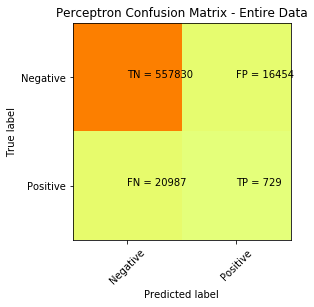

The Confusion matrix tells us that data is not linearly separable although it has only two classes. 
 To classify this data properly we have to apply non linear classification techniques.


In [20]:
#A single layer perceptron will only converge if the input vectors are linearly separable. 
# In this state, all input vectors would be classified correctly indicating linear separability. 
# It will not converge if they are not linearly separable. In other words, it will not classify 
# correctly if the data set is not linearly separable. For our testing purpose, this is exactly what we need 


plt.clf() 

df = df_final_1
df = df.drop(columns=['id','target'],axis=1)
# x = df.loc[:, :'target'].values
x = df.values
y = df_final_1.target
  
#Perform feature scaling
sc= StandardScaler()
x = sc.fit_transform(x)

perceptron = Perceptron(random_state = 0)
perceptron.fit(x, y)
predicted = perceptron.predict(x)



cm = confusion_matrix(y, predicted)
 
plt.clf() 
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Perceptron Confusion Matrix - Entire Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
  
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

print('The Confusion matrix tells us that data is not linearly separable although it has only two classes.','\n','To classify this data properly we have to apply non linear classification techniques.')

# Data Split 80-20% train_test Split

In [21]:
# data_final_1.target = data_final_1.target.astype('category')
data_model = df_final_1.drop(columns=['id','target'],axis=1)
y = df_final_1.target

In [22]:
X_train,X_test,y_train,y_test = train_test_split(data_model,y,test_size = 0.2,random_state=42,shuffle=True)

In [23]:
print('Train data shape {} \n Test data shape {} \n  Train target shape{} \n  Test target shape {}'.format(X_train.shape,X_test.shape,y_train.shape,y_test.shape))

Train data shape (476800, 54) 
 Test data shape (119200, 54) 
  Train target shape(476800,) 
  Test target shape (119200,)


# Controlling Class Imbalance

In [24]:
print('-The cause of not finding a linear decision boundary must be related to class imbalance. \n -As the number of FN & FP cases are very high. \n The posibility of not getting linear boundary might be related to the fact that number of classes for a particular class must be very less. \n -So the classifier is unable to build a proper decision boundary.\n -Chance of overfitting is also considerably high')

-The cause of not finding a linear decision boundary must be related to class imbalance. 
 -As the number of FN & FP cases are very high. 
 The posibility of not getting linear boundary might be related to the fact that number of classes for a particular class must be very less. 
 -So the classifier is unable to build a proper decision boundary.
 -Chance of overfitting is also considerably high


In [25]:
print('Number of observations from class "0"-> {} \n Number of classes from class "1"-> {}'.format(y.value_counts()[0],y.value_counts()[1]))
print('\n')
print('Percentage of class "0"-> {} \n Percentage of class "1"-> {}'.format(y.value_counts()[0]/len(y) *100,y.value_counts()[1]/len(y) *100))

Number of observations from class "0"-> 574284 
 Number of classes from class "1"-> 21716


Percentage of class "0"-> 96.35637583892618 
 Percentage of class "1"-> 3.6436241610738254


In [26]:
print("Before underSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before underSampling, counts of label '0': {} \n".format(sum(y_train==0)))

# sm = SMOTEENN(ratio='minority',random_state=42)


# sm  = SMOTE(random_state=12,n_jobs = 16)
sm  = RandomUnderSampler(random_state=42)


X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After underSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After underSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After underSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After underSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before underSampling, counts of label '1': 17261
Before underSampling, counts of label '0': 459539 

After underSampling, the shape of train_X: (34522, 54)
After underSampling, the shape of train_y: (34522,) 

After underSampling, counts of label '1': 17261
After underSampling, counts of label '0': 17261


# Dimensionality reduction

In [27]:
n_components = 15

#Perform feature scaling
sc= StandardScaler()
X_train_ = sc.fit_transform(X_train_res)
X_test_ = sc.fit_transform(X_test)

print("Extracting the top %d eigen valeus from %d items"
      % (n_components, X_train.shape[0]))
start = time.time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)

end_ = time.time()
print("done in %0.3fs" % (end_ - start))

# eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigen values orthonormal basis")
end = time.time()
X_train_pca = pca.transform(X_train_)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (end-start))

print('train shape:',X_train_pca.shape)
print('test shape:',X_test_pca.shape)



print('Explained Variance: %3f'%sum(pca.explained_variance_ratio_))

Extracting the top 15 eigen valeus from 476800 items
done in 4.983s
Projecting the input data on the eigen values orthonormal basis
done in 4.983s
train shape: (34522, 15)
test shape: (119200, 15)
Explained Variance: 0.990580


# Model

In [28]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# KNN

In [29]:
knn = KNeighborsClassifier(n_jobs=31,n_neighbors=5,weights='distance')

In [30]:
knn.fit(X_train_pca,y_train_res)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=31, n_neighbors=5, p=2,
           weights='distance')

CPU times: user 23min 40s, sys: 1.65 s, total: 23min 42s
Wall time: 47 s
Recall metric in the train dataset: 81.79573512906846%
Recall: 81.79573512906846


Precision: 3.70110809795139
F1: 7.081778606965175
Accuracy: 19.778523489932887
ROC_AUC:, 49.58321333123431


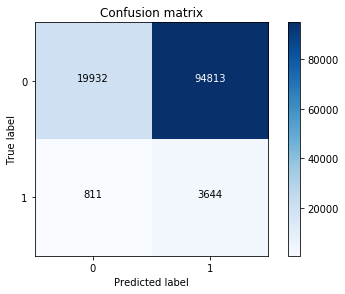

In [31]:
%time y_train_pre = knn.predict(X_test_pca)
cnf_matrix_tra = confusion_matrix(y_test, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))



print('Recall:',recall_score(y_test,y_train_pre)*100)
print('\n')

print('Precision:',precision_score(y_test,y_train_pre)*100)


print('F1:',f1_score(y_test,y_train_pre)*100)

print('Accuracy:',accuracy_score(y_test,y_train_pre)*100)
print('ROC_AUC:,',roc_auc_score(y_test,y_train_pre)*100)


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

# Random Forest

In [32]:
rfc = RandomForestClassifier(n_jobs=31,n_estimators=100,verbose=1,class_weight='balanced')

In [33]:
%time rfc.fit(X_train_pca,y_train_res)

[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.


CPU times: user 24.6 s, sys: 259 ms, total: 24.9 s
Wall time: 1.17 s


[Parallel(n_jobs=31)]: Done 100 out of 100 | elapsed:    1.1s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=31, oob_score=False,
            random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done 100 out of 100 | elapsed:    0.1s finished


CPU times: user 1.1 s, sys: 39.1 ms, total: 1.14 s
Wall time: 216 ms
Recall metric in the train dataset: 21.414141414141415%
Recall: 21.41414141414141


Precision: 3.4756630719906734
F1: 5.980628780992384
Accuracy: 74.83640939597316
ROC_AUC:, 49.16234108922244


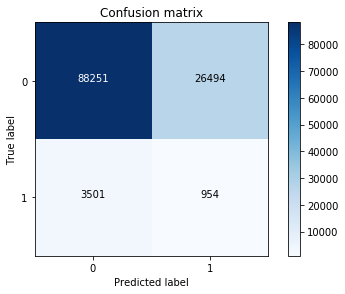

In [34]:
%time y_train_pre = rfc.predict(X_test_pca)
cnf_matrix_tra = confusion_matrix(y_test, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))



print('Recall:',recall_score(y_test,y_train_pre)*100)
print('\n')
print('Precision:',precision_score(y_test,y_train_pre)*100)
print('F1:',f1_score(y_test,y_train_pre)*100)
print('Accuracy:',accuracy_score(y_test,y_train_pre)*100)
print('ROC_AUC:,',roc_auc_score(y_test,y_train_pre)*100)



class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

# Boosting


# Ada boost

In [35]:
adabst = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),learning_rate=0.75,n_estimators=100)

In [36]:
%time adabst.fit(X_train_pca,y_train_res)

CPU times: user 1.22 s, sys: 116 ms, total: 1.34 s
Wall time: 1.16 s


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.75, n_estimators=100, random_state=None)

WITH CLASS IMBALANCE
CPU times: user 24.9 ms, sys: 11 µs, total: 24.9 ms
Wall time: 22.6 ms
Recall metric in the train dataset: 8.507295173961841%
Recall: 8.50729517396184


Precision: 5.4808387563268255
F1: 6.666666666666667
Accuracy: 91.09731543624162
ROC_AUC:, 51.40559320552639


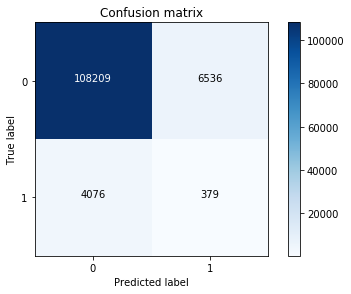

In [37]:
print('WITH CLASS IMBALANCE')

%time y_train_pre = adabst.predict(X_test_pca)
cnf_matrix_tra = confusion_matrix(y_test, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))




print('Recall:',recall_score(y_test,y_train_pre)*100)
print('\n')
print('Precision:',precision_score(y_test,y_train_pre)*100)
print('F1:',f1_score(y_test,y_train_pre)*100)
print('Accuracy:',accuracy_score(y_test,y_train_pre)*100)
print('ROC_AUC:,',roc_auc_score(y_test,y_train_pre)*100)


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

# Gradient Boosting

In [38]:
gb = GradientBoostingClassifier(n_estimators=800,random_state=42,verbose=1,learning_rate=0.75)

In [39]:
%time gb.fit(X_train_pca,y_train_res)

      Iter       Train Loss   Remaining Time 
         1           1.3667           52.09s
         2           1.3565           55.35s
         3           1.3511           53.47s
         4           1.3470           53.94s
         5           1.3440           54.11s
         6           1.3418           52.87s
         7           1.3397           51.90s
         8           1.3374           51.21s
         9           1.3352           51.23s
        10           1.3335           50.82s
        20           1.3174           49.38s
        30           1.3035           48.28s
        40           1.2913           47.41s
        50           1.2813           46.38s
        60           1.2705           45.38s
        70           1.2595           44.61s
        80           1.2496           43.81s
        90           1.2381           43.09s
       100           1.2257           42.56s
       200           1.1290           36.67s
       300           1.0425           30.46s
       40

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.75, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=800,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=1, warm_start=False)

WITH CLASS IMBALANCE
CPU times: user 1.04 s, sys: 7.78 ms, total: 1.05 s
Wall time: 1.04 s
Recall metric in the train dataset: 33.9618406285073%
Recall: 33.9618406285073


Precision: 3.7167141593789923
F1: 6.700174921949384
Accuracy: 64.6501677852349
ROC_AUC:, 49.90174475104828


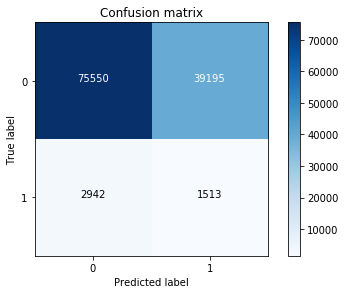

In [40]:
print('WITH CLASS IMBALANCE')

%time y_train_pre = gb.predict(X_test_pca)
cnf_matrix_tra = confusion_matrix(y_test, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))




print('Recall:',recall_score(y_test,y_train_pre)*100)
print('\n')
print('Precision:',precision_score(y_test,y_train_pre)*100)
print('F1:',f1_score(y_test,y_train_pre)*100)
print('Accuracy:',accuracy_score(y_test,y_train_pre)*100)
print('ROC_AUC:,',roc_auc_score(y_test,y_train_pre)*100)


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

# Test Predictions

In [41]:
test_data = pd.read_csv('data_test.csv')

In [42]:
null_col = list(col_null(test_data))
print(null_col)

['num18', 'num19', 'num22', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8', 'cat10', 'cat12']


In [43]:
# Percentage of data missing wrt whole data

print(test_data[null_col].isnull().sum()/test_data.shape[0] *100)

direct_drop_col = ['cat6','cat8']

num18    18.109442
num19     0.000112
num22     7.146489
cat1      0.034386
cat2      0.016241
cat3      0.975565
cat4      0.017921
cat5      0.000560
cat6     69.097216
cat8     44.842274
cat10     1.941161
cat12     0.098229
dtype: float64


In [44]:
list(data_eda_generator(test_data,test_data.columns))


[('id', 892816, numpy.int64),
 ('num1', 8, numpy.int64),
 ('num2', 12, numpy.int64),
 ('num3', 2, numpy.int64),
 ('num4', 2, numpy.int64),
 ('num5', 2, numpy.int64),
 ('num6', 2, numpy.int64),
 ('num7', 2, numpy.int64),
 ('num8', 2, numpy.int64),
 ('num9', 2, numpy.int64),
 ('num10', 2, numpy.int64),
 ('num11', 5, numpy.int64),
 ('num12', 14, numpy.int64),
 ('num13', 2, numpy.int64),
 ('num14', 2, numpy.int64),
 ('num15', 2, numpy.int64),
 ('num16', 10, numpy.float64),
 ('num17', 19, numpy.float64),
 ('num18', 5046, numpy.float64),
 ('num19', 5, numpy.float64),
 ('num20', 201, numpy.float64),
 ('num21', 83769, numpy.float64),
 ('num22', 885, numpy.float64),
 ('num23', 15, numpy.float64),
 ('der1', 10, numpy.float64),
 ('der2', 10, numpy.float64),
 ('der3', 10, numpy.float64),
 ('der4', 6, numpy.int64),
 ('der5', 7, numpy.int64),
 ('der6', 10, numpy.int64),
 ('der7', 10, numpy.int64),
 ('der8', 12, numpy.int64),
 ('der9', 8, numpy.int64),
 ('der10', 26, numpy.int64),
 ('der11', 21, nump

In [45]:
#  Creating dataframe for imputation
# Selecting columns with null values
# Direct_drop_col = 'cat6','cat8'

id_ = test_data.id

drop_col = null_col + ['id'] 

data_impute = test_data.drop(columns=drop_col)

data_impute = change_data_type(data_impute,'category','cat')

y_labels_columns = [x for x in null_col if x not in direct_drop_col]

In [46]:
data_pr = change_data_type(test_data,'category','cat')

In [47]:
out_imputed = list(impute_generator(data=data_pr,columns=y_labels_columns))

drop_list :: 	 ['num19', 'num22', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat10', 'cat12', 'id', 'cat6', 'cat8']
performing regression
num18 fitting in model
Shape of training data for rf : (264563, 44)
num18 prediction done
drop_list :: 	 ['num18', 'num22', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat10', 'cat12', 'id', 'cat6', 'cat8']
performing regression
num19 fitting in model
Shape of training data for rf : (2, 44)
num19 prediction done
drop_list :: 	 ['num18', 'num19', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat10', 'cat12', 'id', 'cat6', 'cat8']
performing regression
num22 fitting in model
Shape of training data for rf : (118429, 44)
num22 prediction done
drop_list :: 	 ['num18', 'num19', 'num22', 'cat2', 'cat3', 'cat4', 'cat5', 'cat10', 'cat12', 'id', 'cat6', 'cat8']
performing classification
cat1 fitting in model
Shape of training data for rf : (614, 44)
cat1 prediction done
drop_list :: 	 ['num18', 'num19', 'num22', 'cat1', 'cat3', 'cat4', 'cat5', 'cat10', 'cat12', 'id', 'c

In [48]:
imputed_data = update_data(data=data_pr,list_=out_imputed)


Processing num18
Processing num19
Processing num22
Processing cat1
Processing cat2
Processing cat3
Processing cat4
Processing cat5
Processing cat10
Processing cat12


In [49]:
# Dropping 'cat6' and 'cat8'
#  Due to High Percentage of missing values 

data_final = imputed_data.drop(columns=direct_drop_col)
data_final.isnull().any()

id       False
num1     False
num2     False
num3     False
num4     False
num5     False
num6     False
num7     False
num8     False
num9     False
num10    False
num11    False
num12    False
num13    False
num14    False
num15    False
num16    False
num17    False
num18    False
num19    False
num20    False
num21    False
num22    False
num23    False
der1     False
der2     False
der3     False
der4     False
der5     False
der6     False
der7     False
der8     False
der9     False
der10    False
der11    False
der12    False
der13    False
der14    False
der15    False
der16    False
der17    False
der18    False
der19    False
cat1     False
cat2     False
cat3     False
cat4     False
cat5     False
cat7     False
cat9     False
cat10    False
cat11    False
cat12    False
cat13    False
cat14    False
dtype: bool

In [50]:
print('Shape of test data loaded ({}) "VS" Shape of test data after preprocess ({})'.format(test_data.shape,data_final.shape))


Shape of test data loaded ((892816, 57)) "VS" Shape of test data after preprocess ((892816, 55))


In [51]:
categorical_columns = ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat7', 'cat9','cat10', 'cat11', 'cat12', 'cat13','cat14']
# data_final_cat14_drop = data_final.drop(columns=['cat14'])

# Dropping cat14 - 104 categories

In [52]:
# Handling categorical 

df_final_1 = MultiColumnLabelEncoder(columns = categorical_columns).fit_transform(data_final)

In [53]:
df_final_1 = df_final_1.drop(columns=['id'])

In [54]:
#PCA 
sc= StandardScaler()
X_train_ = sc.fit_transform(df_final_1)
X_test_pred_pca = pca.transform(X_train_)


In [55]:
# check the length of id column
len(id_),X_test_pred_pca.shape

(892816, (892816, 15))

In [56]:
y_pred = adabst.predict(X_test_pred_pca)

In [57]:
result = pd.DataFrame()

In [58]:
result['id']  = id_
result['target'] = y_pred

In [59]:
result.to_csv('test_result.csv',index=False)

In [60]:
result.shape

(892816, 2)